In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.stats.kde import gaussian_kde
from numpy import linspace
import time
from scipy import interpolate

In [2]:
from natal_kick_tools import mandel_muller_likelihood_functions as mmf

In [3]:
# this is just a little function that we will use to make the plot more beautiful (bigger ticks, labels)
# However, you do not have to use this (just uncommoment "layoutAxes" everywhere)
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = 18, second=False, labelpad=None, setMinor=True):
    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
    ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    
    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax


In [4]:
# Define the models of interest
bh_kicks=[200]
ns_kicks = [200, 400, 800]
sigmas = [0.01, 0.3, 0.7]

# Define the location of the posterior data
pulsar_data_loc = "../correctedPulsarPosteriors/correctedVtData"

# Read Velocity Data

## Model Velocities

In [5]:
# Some UGLY but functional definitions to plot specific ns_kick values
NS_200_RANGE = [0,1,2]
NS_400_RANGE = [3,4,5]
NS_800_RANGE = [6,7,8]

SIGMA_001_RANGE = [0,3,6]
SIGMA_03_RANGE = [1,4,7]
SIGMA_07_RANGE = [2,5,8]

In [6]:
NS_KICKS_3D = []
NS_KICKS_2D = []
NS_KICK_MULT = [] 
SIGMAS = []

for ns_kick in ns_kicks:
    for sigma in sigmas:
        fname = f"model_velocities/vns_{ns_kick}_sigma_{sigma}_velocities"
        v_3d, v_2d = np.loadtxt(fname, skiprows=1, unpack=True)
        NS_KICKS_3D.append(v_3d)
        NS_KICKS_2D.append(v_2d)
        NS_KICK_MULT.append(ns_kick)
        SIGMAS.append(sigma)        

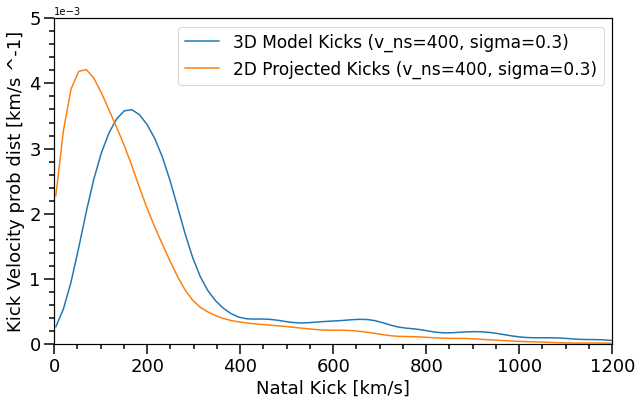

In [7]:
f, ax= plt.subplots(1, 1,  figsize=(10,6)) 

PLOT_RANGE = np.intersect1d(NS_400_RANGE, SIGMA_03_RANGE)

for i in PLOT_RANGE:
    kde_NS_3D = gaussian_kde( NS_KICKS_3D[i] )
    kde_NS_2D = gaussian_kde( NS_KICKS_2D[i] )
    NS_dist_space = linspace( min(NS_KICKS_3D[i]), max(NS_KICKS_3D[i]), 100 )
    
    plt.plot( NS_dist_space, kde_NS_3D(NS_dist_space), label=f'3D Model Kicks (v_ns={NS_KICK_MULT[i]}, sigma={SIGMAS[i]})');
    plt.plot( NS_dist_space, kde_NS_2D(NS_dist_space), label=f'2D Projected Kicks (v_ns={NS_KICK_MULT[i]}, sigma={SIGMAS[i]})');

layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
           nameY='Kick Velocity prob dist [km/s ^-1]')

plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))

plt.ylim(0, 5e-3)
plt.xlim(0, 1200)

plt.legend(fontsize=17)
plt.show()

# Read Likelihood Data

In [8]:
p_models = []
columns = [] # labels for plotting later
for ns_kick in ns_kicks:
    for sigma in sigmas:
        fname = f"calculatedModelLikelihoods/vns_{ns_kick}_sigma_{sigma}"
        all_likelihoods = np.loadtxt(fname)
        p_models.append(np.prod(all_likelihoods))
        
        col_name = f"vns_{ns_kick}_sigma_{sigma}"
        columns.append(col_name)
        
# normalize the array
p_models = p_models/np.sum(p_models)

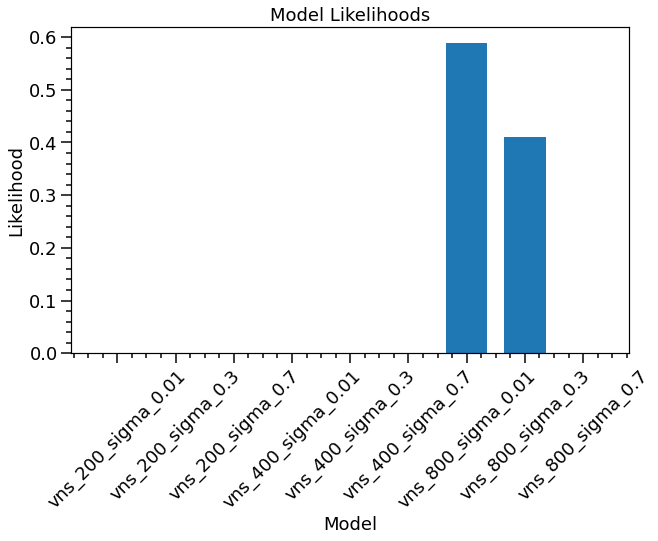

In [12]:
f, ax= plt.subplots(1, 1,  figsize=(10,6)) 

x_range = np.linspace(0, len(p_models), len(p_models))
plt.bar(x_range, p_models, tick_label=columns)

layoutAxes(ax=ax, nameX='Model',\
           nameY='Likelihood')
plt.xticks(rotation=45)
# plt.semilogy()

plt.title("Model Likelihoods", fontsize=18)

plt.show()

# CDF Plots

In [10]:
# Takes about 20 s
start = time.time()

vt_all = []

for file in glob.glob('../correctedPulsarPosteriors/correctedVtData/*.bootstraps'):
    vt_all.append(np.loadtxt(file, unpack=True, usecols=5))

end = time.time()
print(end - start)

23.172823905944824


In [13]:
np.min(vt_all[0])

41.961665

In [14]:
def set_bins_from_posterior(vt_all, n_bins=10):
    v_min = 500
    v_max = 0
    
    for i in range(len(vt_all)):
        v_min = min(v_min, np.min(vt_all[i]))
        v_max = max(v_max, np.max(vt_all[i]))
        
    v_max = min(v_max, 1000)
    bins = np.linspace(v_min, v_max, n_bins+1)
    return bins

In [15]:
def draw_posterior_cdf(vt_all, n_bins=10):
    
    vt_draw = np.zeros(len(vt_all))    
    
    bins = set_bins_from_posterior(vt_all, n_bins=n_bins) 
    
    for i in range(len(vt_all)):
        vt_draw[i] = vt_all[i][np.random.randint(len(vt_all[i]))]
    
    count, bins_count = np.histogram(vt_draw, bins=bins)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    
    return vt_draw, bins_count[1:], cdf

In [16]:
def draw_model_cdf(model, n=len(vt_all), n_bins=10):
    vt_draw = np.zeros(n)
    
    bins = set_bins_from_posterior(vt_all, n_bins=n_bins) 
    
    for i in range(n):
        vt_draw[i] = model[np.random.randint(len(model))]
    
    count, bins_count = np.histogram(vt_draw, bins=bins)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    
    return vt_draw, bins_count[1:], cdf

In [17]:
def plot_model_cdf(n_cdf, PLOT_INDEX=0, color='b'):
    for i in range(n_cdf):
        vt_draw, bins, cdf = draw_model_cdf(NS_KICKS_2D[PLOT_INDEX], len(vt_all))
        plt.plot(bins, cdf, color=color, alpha = 10/n_cdf)
    plt.plot(bins, cdf, color=color, alpha = 10/n_cdf, label=f'2D Projected Kicks (v_ns={NS_KICK_MULT[PLOT_INDEX]}, sigma={SIGMAS[PLOT_INDEX]})')
    

In [18]:
def plot_posterior_cdf(n_cdf, color='b'):
    for i in range(n_cdf):
        vt_draw, bins, cdf = draw_posterior_cdf(vt_all)
        plt.plot(bins, cdf, color=color, alpha = 10/n_cdf)
    plt.plot(bins, cdf, color=color, alpha = 10/n_cdf, label='Posterior CDF')
    

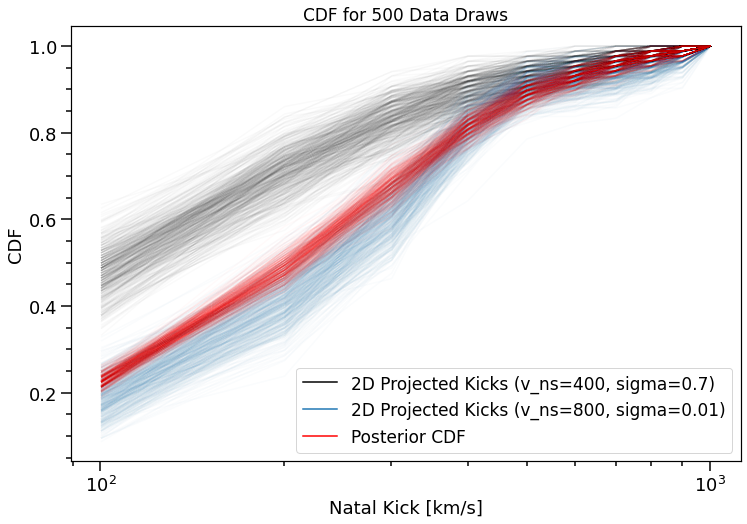

Plot completed in 23.537679 s


In [19]:
n_cdf = 500

f, ax= plt.subplots(1, 1,  figsize=(12,8)) 

start = time.time()

index_400_07 = np.intersect1d(NS_400_RANGE, SIGMA_07_RANGE)[0]
index_800_001 = np.intersect1d(NS_800_RANGE, SIGMA_001_RANGE)[0]


plot_model_cdf(n_cdf, index_400_07, color='k')
plot_model_cdf(n_cdf, index_800_001, color='C0')

plot_posterior_cdf(n_cdf, color='r')



layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
           nameY='CDF')

plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))

plt.title(f"CDF for {n_cdf} Data Draws", fontsize=17)

leg = plt.legend(fontsize=17)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
    
plt.semilogx()
plt.show()

end = time.time()
print(f"Plot completed in {end - start:2f} s")

In [20]:
def get_avg_model_cdf(n_cdf, PLOT_INDEX, n_bins=10):
   
    cdf_all = np.zeros((n_cdf, n_bins))
    
    for i in range(n_cdf):
        vt_draw, bins, cdf = draw_model_cdf(NS_KICKS_2D[PLOT_INDEX], n=len(vt_all), n_bins=n_bins)
        cdf_all[i] = cdf
        
    cdf_med = np.median(cdf_all, axis=0)
    cdf_min = np.min(cdf_all, axis=0)
    cdf_max = np.max(cdf_all, axis=0)
    
    return bins, cdf_med, cdf_min, cdf_max

In [21]:
def get_avg_posterior_cdf(n_cdf, vt_all, n_bins=10):
   
    cdf_all = np.zeros((n_cdf, n_bins))
    
    for i in range(n_cdf):
        vt_draw, bins, cdf = draw_posterior_cdf(vt_all, n_bins=n_bins)
        cdf_all[i] = cdf
        
    cdf_med = np.median(cdf_all, axis=0)
    cdf_min = np.min(cdf_all, axis=0)
    cdf_max = np.max(cdf_all, axis=0)
    
    return bins, cdf_med, cdf_min, cdf_max

In [22]:
def plot_avg_model_cdf(n_cdf, PLOT_INDEX, n_bins=10, color='C0'):
    bins, cdf_med, cdf_min, cdf_max = get_avg_model_cdf(n_cdf, PLOT_INDEX, n_bins=n_bins)
    
    plt.plot(bins, cdf_med, color=color, label=f'2D Projected Kicks (v_ns={NS_KICK_MULT[PLOT_INDEX]}, sigma={SIGMAS[PLOT_INDEX]})')
    plt.fill_between(bins, cdf_min, cdf_max, color=color, alpha=0.2)
    
    return

In [23]:
def plot_avg_posterior_cdf(n_cdf, vt_all, n_bins=10, color='C0'):
    bins, cdf_med, cdf_min, cdf_max = get_avg_posterior_cdf(n_cdf, vt_all, n_bins=n_bins)
    
    plt.plot(bins, cdf_med, color=color, label='Posterior CDF')
    plt.fill_between(bins, cdf_min, cdf_max, color=color, alpha=0.2)
    
    return

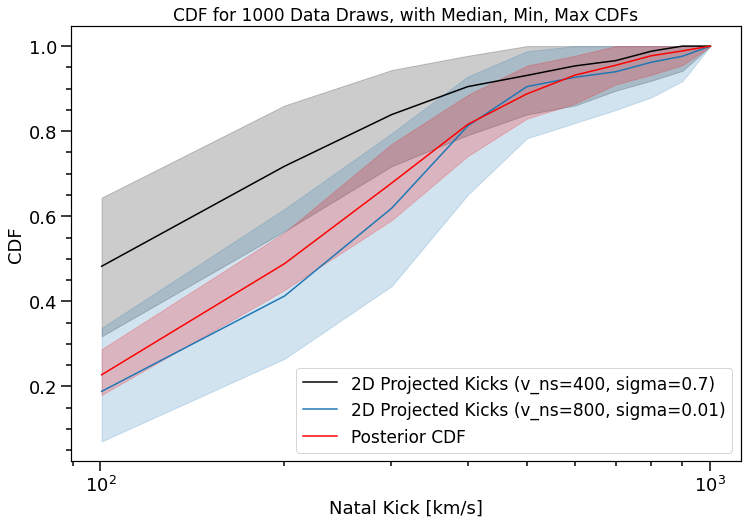

In [26]:
n_cdf = 1000
n_bins = 10

f, ax= plt.subplots(1, 1,  figsize=(12,8)) 

index_400_07 = np.intersect1d(NS_400_RANGE, SIGMA_07_RANGE)[0]
index_800_001 = np.intersect1d(NS_800_RANGE, SIGMA_001_RANGE)[0]


plot_avg_model_cdf(n_cdf, index_400_07, n_bins=n_bins, color='k')
plot_avg_model_cdf(n_cdf, index_800_001, n_bins=n_bins, color='C0')


plot_avg_posterior_cdf(n_cdf, vt_all, n_bins=n_bins, color='r')


layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
           nameY='CDF')


plt.title(f"CDF for {n_cdf} Data Draws, with Median, Min, Max CDFs", fontsize=17)

plt.legend(fontsize=17)
    
    
plt.semilogx()
plt.show()
